# Simple Queue Model (M/M/c/K) Analysis with PyDASA

This notebook demonstrates **dimensional analysis** of queueing systems using PyDASA with a simplified custom dimensional framework (Time [T], Structure [S]). We'll explore:

1. Define a simple custom dimensional framework/domain (Time, Structure)
2. Model queue variables with minimal dimensions
3. Use PyDASA's `AnalysisEngine` to derive dimensionless groups
4. Understand the M/M/c/K queue model
5. Visualize dimensionless behavior

## M/M/c/K Queue Model

The **M/M/c/K** queue model:
- **M**: Markovian arrivals with rate $\lambda$ [req/s]
- **M**: Markovian service with rate $\mu$ [req/s]
- **c**: Number of parallel servers [req]
- **K**: Maximum system capacity [req]

### Simplified Dimensional Framework (T, S)

We use only two fundamental dimensions:
- **T** (Time): Temporal measurements [seconds, sec, s]
- **S** (Structure): System capacity and servers [requests, req, msg]

This minimal framework allows us to derive key dimensionless numbers for queue analysis.

## 1. Import Required Libraries

In [1]:
# PyDASA imports
import pydasa
from pydasa.workflows.phenomena import AnalysisEngine
from pydasa.elements.parameter import Variable
from pydasa.dimensional.vaschy import Schema

# For visualization
import numpy as np
import matplotlib.pyplot as plt

print(f"PyDASA Version: {pydasa.__version__}")
print("Libraries imported successfully!")

PyDASA Version: 0.6.11
Libraries imported successfully!


## 2. Define Simplified Custom Dimensional Framework

We create a custom framework with only **two** fundamental dimensions:

1. **T (Time)**: Temporal measurements [s]
2. **S (Structure)**: System capacity [requests]

This is analogous to the Reynolds number analysis where we use Length (L), Time (T), and Mass (M).

In [2]:
# Define simplified FDU list (only T and S)
fdu_list = [
    {
        "_idx": 0,
        "_sym": "T",
        "_fwk": "CUSTOM",
        "description": "Temporal measurements",
        "_unit": "s",
        "_name": "Time"
    },
    {
        "_idx": 1,
        "_sym": "S",
        "_fwk": "CUSTOM",
        "description": "System capacity and structural resources",
        "_unit": "requests",
        "_name": "Structure"
    }
]

# Create schema
schema = Schema(_fwk="CUSTOM", _fdu_lt=fdu_list)

print("=== Simplified Custom Framework Created ===")
print(f"Framework: {schema.fwk}")
print(f"Number of FDUs: {len(schema._fdu_lt)}")
print("\nFundamental Dimensional Units:")
for fdu in schema._fdu_lt:
    print(f"  {fdu._sym} ({fdu._name}): {fdu._unit} - {fdu.description}")

=== Simplified Custom Framework Created ===
Framework: CUSTOM
Number of FDUs: 2

Fundamental Dimensional Units:
  T (Time): s - Temporal measurements
  S (Structure): requests - System capacity and structural resources


## 3. Define Simplified Queue Variables

We define **6 variables** using only T and S dimensions:

**INPUT Variables (2)**:
1. **λ** (lambda): Arrival rate [S/T]
2. **K**: Queue capacity [S]

**OUTPUT Variable (1)**:
1. **L**: Average queue length [S]

**CONTROL Variables (3)**:
1. **W**: Average waiting time [T]
2. **μ** (mu): Service rate [S/T]
3. **c**: Number of servers [S]

In [3]:
# Define simplified variables (only using T and S dimensions)
variables_dict = {
    # INPUT VARIABLES
    "\\lambda": {
        "_idx": 0,
        "_sym": "\\lambda",
        "_alias": "lambda",
        "_fwk": "CUSTOM",
        "_cat": "IN",
        "_name": "Arrival Rate",
        "description": "Request arrival rate",
        "relevant": True,
        "_dims": "S*T^-1",
        "_units": "req/s",
        "_setpoint": 100.0,
        "_std_setpoint": 100.0,
        "_std_min": 100.0,
        "_std_max": 500.0,
        "_step": 10.0,
    },
    "K": {
        "_idx": 1,
        "_sym": "K",
        "_alias": "K",
        "_fwk": "CUSTOM",
        "_cat": "IN",
        "_name": "Queue Capacity",
        "description": "Maximum system capacity",
        "relevant": True,
        "_dims": "S",
        "_units": "requests",
        "_setpoint": 10.0,
        "_std_setpoint": 10.0,
    },
    
    # OUTPUT VARIABLE
    "L": {
        "_idx": 2,
        "_sym": "L",
        "_alias": "L",
        "_fwk": "CUSTOM",
        "_cat": "OUT",
        "_name": "Queue Length",
        "description": "Average queue length",
        "relevant": True,
        "_dims": "S",
        "_units": "requests",
        "_setpoint": 0.9946,
        "_std_setpoint": 0.9946,
    },
    
    # CONTROL VARIABLES
    "W": {
        "_idx": 3,
        "_sym": "W",
        "_alias": "W",
        "_fwk": "CUSTOM",
        "_cat": "CTRL",
        "_name": "Waiting Time",
        "description": "Average waiting time",
        "relevant": True,
        "_dims": "T",
        "_units": "s",
        "_setpoint": 0.005,
        "_std_setpoint": 0.005,
    },
    "\\mu": {
        "_idx": 4,
        "_sym": "\\mu",
        "_alias": "mu",
        "_fwk": "CUSTOM",
        "_cat": "CTRL",
        "_name": "Service Rate",
        "description": "Service rate per server",
        "relevant": True,
        "_dims": "S*T^-1",
        "_units": "req/s",
        "_setpoint": 400.0,
        "_std_setpoint": 400.0,
        "_std_min": 200.0,
        "_std_max": 1000.0,
    },
    "c": {
        "_idx": 5,
        "_sym": "c",
        "_alias": "c",
        "_fwk": "CUSTOM",
        "_cat": "CTRL",
        "_name": "Servers",
        "description": "Number of parallel servers",
        "relevant": True,
        "_dims": "S",
        "_units": "requests",
        "_setpoint": 1.0,
        "_std_setpoint": 1.0,
        "_std_min": 1.0,
        "_std_max": 4.0,
        "_std_mean": 2.0,
    },
}

# Convert to Variable instances
variables = {sym: Variable(**params) for sym, params in variables_dict.items()}

print("=== Variables Defined ===")
print(f"Total variables: {len(variables)}")
print(f"Relevant for analysis: {sum(1 for v in variables.values() if v.relevant)}")
print("\nVariable Details:")
print(f"{'Symbol':<10} {'Name':<20} {'Dimensions':<15} {'Category':<10}")
print("-" * 55)
for sym, var in variables.items():
    print(f"{sym:<10} {var.name:<20} {var.dims:<15} {var.cat:<10}")

=== Variables Defined ===
Total variables: 6
Relevant for analysis: 6

Variable Details:
Symbol     Name                 Dimensions      Category  
-------------------------------------------------------
\lambda    Arrival Rate         S*T^-1          IN        
K          Queue Capacity       S               IN        
L          Queue Length         S               OUT       
W          Waiting Time         T               CTRL      
\mu        Service Rate         S*T^-1          CTRL      
c          Servers              S               CTRL      


## 4. Create Analysis Engine and Run Dimensional Analysis

In [4]:
# Create AnalysisEngine
engine = AnalysisEngine(
    _idx=0,
    _fwk="CUSTOM",
    _schema=schema,
    _name="Simple Queue Analysis",
    description="Simplified M/M/c/K analysis with T and S dimensions only"
)

engine.variables = variables

print("=== Running Dimensional Analysis ===")
results = engine.run_analysis()

print(f"\nNumber of Pi Groups: {len(engine.coefficients)}")
print(f"Coefficients: {list(engine.coefficients.keys())}")

print("\n=== Dimensionless Coefficients ===")
for name, coeff in engine.coefficients.items():
    print(f"{name}: {coeff.pi_expr}")

=== Running Dimensional Analysis ===

Number of Pi Groups: 4
Coefficients: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}']

=== Dimensionless Coefficients ===
\Pi_{0}: \frac{L}{K}
\Pi_{1}: \frac{\lambda*W}{K}
\Pi_{2}: \frac{\mu}{\lambda}
\Pi_{3}: \frac{c}{K}


## 5. Derive Meaningful Dimensionless Coefficients

From the Pi groups, we derive operationally meaningful coefficients:

1. **Occupancy Coefficient ($\sigma$)**: Queue capacity utilization - $\sigma = \Pi_0 = L/K$
2. **Stall Coefficient ($\delta$)**: Service blocking indicator - $\delta = \Pi_1 = W\cdot\lambda/L$
3. **Effective-Yield Coefficient ($\eta$)**: Resource utilization effectiveness - $\eta = \Pi_2^{-1}\cdot\Pi_3^{-1} = K \cdot \lambda/(c \cdot \mu)$

In [5]:
# Get Pi coefficient keys
pi_keys = list(engine.coefficients.keys())

# Derive meaningful coefficients based on available Pi groups
print("=== Deriving Operational Coefficients ===")

# Derive Occupancy Coefficient: δ = Π₀ = L/K
delta_coeff = engine.derive_coefficient(
    expr=f"{pi_keys[0]}",
    symbol="\\delta",
    name="Occupancy Coefficient",
    description="δ = L/K - Queue occupancy ratio",
    idx=-1
)

# Derive Stall Coefficient: σ = Π₁ = W·λ/L
sigma_coeff = engine.derive_coefficient(
    expr=f"{pi_keys[1]}",
    symbol="\\psi",
    name="Stall Coefficient",
    description="σ = W·λ/L - Service stall/blocking indicator",
    idx=-1
)

# Derive Effective-Yield Coefficient: η = Π₂⁻¹·Π₃⁻¹ = K·λ/(c·μ)
eta_coeff = engine.derive_coefficient(
    # expr=f"{pi_keys[2]} * {pi_keys[3]}**(-1) * {pi_keys[4]}",
    expr=f"{pi_keys[2]}**(-1) * {pi_keys[3]}**(-1)",
    symbol="\\eta",
    name="Effective-Yield Coefficient",
    description="η = K·λ/(c·μ) - Resource utilization effectiveness",
    idx=-1
)

# Calculate numerical values using stored setpoints
delta_val = delta_coeff.calculate_setpoint()
sigma_val = sigma_coeff.calculate_setpoint()
eta_val = eta_coeff.calculate_setpoint()

# Occupancy Coefficient: L/K
print(f"Occupancy: δ=(L/K) = {delta_val:.4f}")

# Stall Coefficient: σ = W·λ/L
print(f"Stall: σ = W·λ/L = {sigma_val:.4f}")

# Effective-Yield Coefficient: η = K·λ/(c·μ)
print(f"Effective-Utility: η = K·λ/(c·μ) = {eta_val:.4f}")

=== Deriving Operational Coefficients ===
Occupancy: δ=(L/K) = 0.0995
Stall: σ = W·λ/L = 0.0500
Effective-Utility: η = K·λ/(c·μ) = 2.5000


## 6. Generate Grid-Based Data

Similar to the full notebook, we generate data by varying K, c, and μ:

In [6]:
from src.queueing import Queue
import itertools
import pandas as pd

print("=== Generating Grid Data ===")

# Grid parameters
K_values = [4, 8, 16]
c_values = [1.0, 2.0, 4.0]
mu_values = [200.0, 500.0, 1000.0]

# Lambda sweep
lambda_zero = 100.0
lambda_step = 10.0
RHO_THLD = 0.95

# Generate configurations
cfg_lt = list(itertools.product(K_values, c_values, mu_values))
print(f"Total configurations: {len(cfg_lt)}")

# Create DataFrame
cols = list(variables.keys())
data_df = pd.DataFrame(columns=cols)

# Generate data
for idx, (K, c, mu) in enumerate(cfg_lt, 1):
    print(f"\t-*- Config {idx}/{len(cfg_lt)}: K={K}, c={c}, μ={mu} -*-")
    lambda_t = lambda_zero
    rho_t = 0.0
    
    while rho_t < RHO_THLD:
        # remember to download custom queueing module for M/M/s/K
        q = Queue("M/M/s/K", lambda_t, mu, int(c), K)
        q.calculate_metrics()
        
        # Order must match cols = ["\\lambda", "K", "L", "W", "\\mu", "c"]
        data_t = [lambda_t, K, q.avg_len, q.avg_wait, mu, c]
        data_df.loc[len(data_df)] = data_t
        
        rho_t = q.rho
        lambda_t += lambda_step

print(f"Generated {len(data_df)} data points")

# Add data to variables
data = data_df.to_dict(orient="list")
for sym, var in variables.items():
    if sym in data:
        var.data = data[sym]

engine.variables = variables
print("Data injected into PyDASA engine!")

=== Generating Grid Data ===
Total configurations: 27
	-*- Config 1/27: K=4, c=1.0, μ=200.0 -*-
	-*- Config 2/27: K=4, c=1.0, μ=500.0 -*-
	-*- Config 3/27: K=4, c=1.0, μ=1000.0 -*-
	-*- Config 4/27: K=4, c=2.0, μ=200.0 -*-
	-*- Config 5/27: K=4, c=2.0, μ=500.0 -*-
	-*- Config 6/27: K=4, c=2.0, μ=1000.0 -*-
	-*- Config 7/27: K=4, c=4.0, μ=200.0 -*-
	-*- Config 8/27: K=4, c=4.0, μ=500.0 -*-
	-*- Config 9/27: K=4, c=4.0, μ=1000.0 -*-
	-*- Config 10/27: K=8, c=1.0, μ=200.0 -*-
	-*- Config 11/27: K=8, c=1.0, μ=500.0 -*-
	-*- Config 12/27: K=8, c=1.0, μ=1000.0 -*-
	-*- Config 13/27: K=8, c=2.0, μ=200.0 -*-
	-*- Config 14/27: K=8, c=2.0, μ=500.0 -*-
	-*- Config 15/27: K=8, c=2.0, μ=1000.0 -*-
	-*- Config 16/27: K=8, c=4.0, μ=200.0 -*-
	-*- Config 17/27: K=8, c=4.0, μ=500.0 -*-
	-*- Config 18/27: K=8, c=4.0, μ=1000.0 -*-
	-*- Config 19/27: K=16, c=1.0, μ=200.0 -*-
	-*- Config 20/27: K=16, c=1.0, μ=500.0 -*-
	-*- Config 21/27: K=16, c=1.0, μ=1000.0 -*-
	-*- Config 22/27: K=16, c=2.0, μ=200.0 -*

## 7. Run Monte Carlo Simulation

In [7]:
from pydasa.workflows.practical import MonteCarloSimulation

print("=== Running Monte Carlo Simulation ===")

mc_grid = MonteCarloSimulation(
    _idx=0,
    _fwk="CUSTOM",
    _schema=schema,
    _name="Simple Grid Queue Analysis",
    _cat="DATA",
    _experiments=len(data_df),
    _variables=engine.variables,
    _coefficients=engine.coefficients
)

mc_grid.run_simulation(iters=len(data_df))

print(f"Simulation complete: {mc_grid.experiments} experiments")
print(f"Results for: {list(mc_grid.results.keys())}")

=== Running Monte Carlo Simulation ===
Simulation complete: 3150 experiments
Results for: ['\\Pi_{0}', '\\Pi_{1}', '\\Pi_{2}', '\\Pi_{3}', '\\delta', '\\psi', '\\eta']


## 8. Visualize Results

Create simplified visualizations of the dimensionless behavior:

In [8]:
# Extract simulation data
all_keys = list(mc_grid.simulations.keys())
derived_keys = [k for k in all_keys if not k.startswith('\\Pi_')]

print("=== Extracting Simulation Results ===")
pi_data = {}
for pi_key in derived_keys:
    print(f"Processing simulation: {pi_key}")
    pi_sim_obj = mc_grid.get_simulation(pi_key)
    pi_results = pi_sim_obj.extract_results()
    for sym, var in pi_sim_obj.variables.items():
        pi_data[sym] = var.data
    pi_data[pi_key] = pi_results[pi_key]

# Get data arrays
print("\n=== Simulation Results Details ===")
if len(derived_keys) > 0:
    delta_sim = pi_data[derived_keys[0]]
    sigma_sim = pi_data[derived_keys[1]]
    eta_sim = pi_data[derived_keys[2]]
    lambda_data = np.array(pi_data["\\lambda"])
    mu_data = np.array(pi_data["\\mu"])
    c_data = np.array(pi_data["c"])
    K_data = np.array(pi_data["K"])

    
    print(f"Occupancy (δ): Mean = {np.mean(delta_sim):.4e}, Range = [{np.min(delta_sim):.4e}, {np.max(delta_sim):.4e}]")
    print(f"Stall (σ): Mean = {np.mean(sigma_sim):.4e}, Range = [{np.min(sigma_sim):.4e}, {np.max(sigma_sim):.4e}]")
    print(f"Effective-Yield (η): Mean = {np.mean(eta_sim):.4e}, Range = [{np.min(eta_sim):.4e}, {np.max(eta_sim):.4e}]")

=== Extracting Simulation Results ===
Processing simulation: \delta
Processing simulation: \psi
Processing simulation: \eta

=== Simulation Results Details ===
Occupancy (δ): Mean = 2.5360e-01, Range = [6.2500e-03, 6.7353e-01]
Stall (σ): Mean = 2.7760e-01, Range = [6.2500e-03, 9.5000e-01]
Effective-Yield (η): Mean = 4.7595e+00, Range = [1.0000e-01, 1.5360e+01]


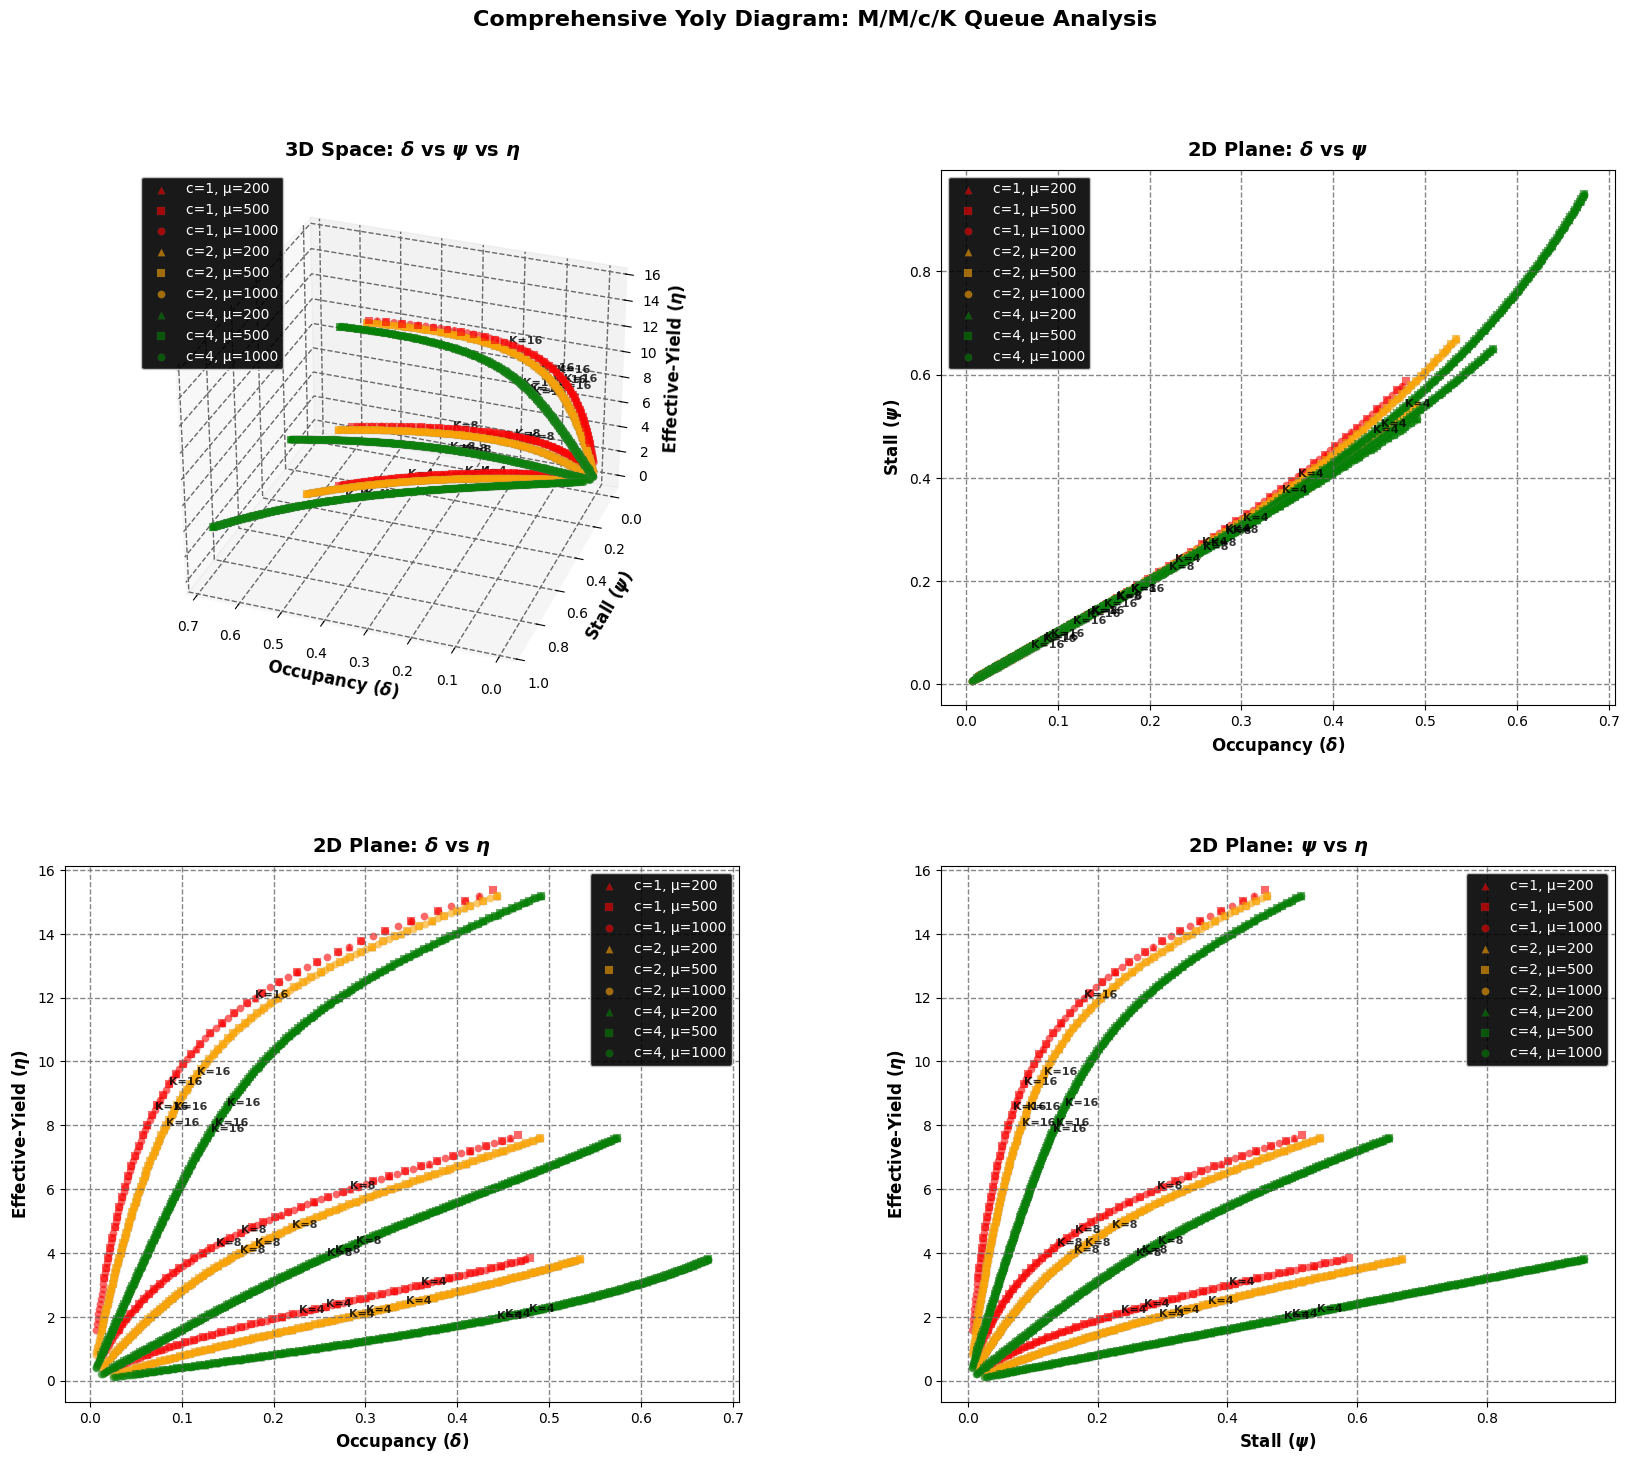

In [9]:
# Create comprehensive Yoly diagram with 3D and 2D projections in a 2x2 grid
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 16), facecolor="white")

# Define grid specification for 2x2 layout
gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)

# Create axes: [0,0] is 3D, others are 2D
axes = [
    [fig.add_subplot(gs[0, 0], projection="3d"), fig.add_subplot(gs[0, 1])],
    [fig.add_subplot(gs[1, 0]), fig.add_subplot(gs[1, 1])]
]

# Auxiliary lists for plot configuration
plot_types = ["3D", "2D", "2D", "2D"]
plot_titles = [
    r"3D Space: $\boldsymbol{\delta}$ vs $\boldsymbol{\psi}$ vs $\boldsymbol{\eta}$",
    r"2D Plane: $\boldsymbol{\delta}$ vs $\boldsymbol{\psi}$",
    r"2D Plane: $\boldsymbol{\delta}$ vs $\boldsymbol{\eta}$",
    r"2D Plane: $\boldsymbol{\psi}$ vs $\boldsymbol{\eta}$"
]

x_labels = [
    r"Occupancy ($\boldsymbol{\delta}$)",
    r"Occupancy ($\boldsymbol{\delta}$)",
    r"Occupancy ($\boldsymbol{\delta}$)",
    r"Stall ($\boldsymbol{\psi}$)"
]

y_labels = [
    r"Stall ($\boldsymbol{\psi}$)",
    r"Stall ($\boldsymbol{\psi}$)",
    r"Effective-Yield ($\boldsymbol{\eta}$)",
    r"Effective-Yield ($\boldsymbol{\eta}$)"
]

z_labels = [r"Effective-Yield ($\boldsymbol{\eta}$)", None, None, None]

# Data pairs for each subplot: (x_data, y_data, z_data or None)
data_pairs = [
    (delta_sim, sigma_sim, eta_sim),    # 3D plot
    (delta_sim, sigma_sim, None),       # delta vs sigma
    (delta_sim, eta_sim, None),         # delta vs eta
    (sigma_sim, eta_sim, None)          # sigma vs eta
]

# Color map for server count (c) and marker map for service rates (μ)
c_data = np.array(variables["c"].data)
mu_data = np.array(variables["\\mu"].data)
K_data = np.array(variables["K"].data)
unique_c = np.unique(c_data)
unique_mu = np.unique(mu_data)
unique_K = np.unique(K_data)

# Colors for servers: red (1), orange (2), green (4)
color_map = {1.0: "red", 2.0: "orange", 4.0: "green"}
# Markers for service rate: triangle (slow), square (mid), circle (fast)
marker_map = {200: "^", 500: "s", 1000: "o"}

# Iterate over 2x2 grid
plot_idx = 0
for row in range(2):
    for col in range(2):
        ax = axes[row][col]
        plot_type = plot_types[plot_idx]
        x_data, y_data, z_data = data_pairs[plot_idx]

        # Set white background for subplot
        ax.set_facecolor("white")

        # Track which (c, μ) combinations have been labeled for legend
        labeled_combinations = set()

        # Plot data points grouped by server count (c), service rate (μ), and capacity (K)
        for c_val in unique_c:
            for mu_val in unique_mu:
                for K_val in unique_K:
                    # Create mask for this specific combination
                    mask = (np.abs(c_data - c_val) < 0.1) & (np.abs(mu_data -
                                                                    mu_val) < 0.1) & (np.abs(K_data - K_val) < 0.1)
                    if not np.any(mask):
                        continue

                    # Create label only once per (c, μ) combination
                    combo_key = (c_val, mu_val)
                    if combo_key not in labeled_combinations:
                        label = f"c={int(c_val)}, μ={int(mu_val)}"
                        labeled_combinations.add(combo_key)
                    else:
                        label = None  # No label for subsequent K values

                    color = color_map.get(c_val, "gray")
                    marker = marker_map.get(mu_val, "o")

                    if plot_type == "3D":
                        # 3D scatter plot
                        ax.scatter(x_data[mask], y_data[mask], z_data[mask],
                                   c=color, marker=marker, s=30, alpha=0.6,
                                   edgecolors="grey", linewidths=0.1,
                                   label=label)
                        # Add ONE K value label at median position of this cluster
                        mask_indices = np.where(mask)[0]
                        if len(mask_indices) > 0:
                            mid_idx = mask_indices[len(mask_indices)//2]
                            ax.text(x_data[mid_idx], y_data[mid_idx], z_data[mid_idx],
                                    f"K={int(K_val)}", fontsize=8, color="black",
                                    fontweight="bold", alpha=0.8)
                    else:
                        # 2D scatter plot
                        ax.scatter(x_data[mask], y_data[mask],
                                   c=color, marker=marker, s=30, alpha=0.6,
                                   edgecolors="grey", linewidths=0.1,
                                   label=label)
                        # Add ONE K value label at median position of this cluster
                        mask_indices = np.where(mask)[0]
                        if len(mask_indices) > 0:
                            mid_idx = mask_indices[len(mask_indices)//2]
                            ax.text(x_data[mid_idx], y_data[mid_idx],
                                    f"K={int(K_val)}", fontsize=8, color="black",
                                    fontweight="bold", alpha=0.8)

        # Apply plot-specific styling after all data points are plotted
        if plot_type == "3D":
            ax.set_zlabel(z_labels[plot_idx],
                          fontsize=12, fontweight="bold",
                          color="black")
            ax.view_init(elev=30, azim=110)

            # Enable 3D grid with explicit settings for each axis
            ax.grid(True, color="dimgray", linewidth=1,
                    linestyle="--", alpha=0.9)
            ax.xaxis._axinfo["grid"]["color"] = "dimgray"
            ax.xaxis._axinfo["grid"]["linewidth"] = 1
            ax.xaxis._axinfo["grid"]["linestyle"] = "--"
            ax.yaxis._axinfo["grid"]["color"] = "dimgray"
            ax.yaxis._axinfo["grid"]["linewidth"] = 1
            ax.yaxis._axinfo["grid"]["linestyle"] = "--"
            ax.zaxis._axinfo["grid"]["color"] = "dimgray"
            ax.zaxis._axinfo["grid"]["linewidth"] = 1
            ax.zaxis._axinfo["grid"]["linestyle"] = "--"

            # Black tick parameters for 3D
            ax.tick_params(axis="x", colors="black")
            ax.tick_params(axis="y", colors="black")
            ax.tick_params(axis="z", colors="black")
        else:
            # 2D styling
            ax.grid(True, alpha=0.8,
                    color="dimgray", linewidth=1.0, linestyle="--")
            ax.tick_params(colors="black", which="both")
            for spine in ax.spines.values():
                spine.set_edgecolor("black")

        # Set labels and title with black font
        ax.set_xlabel(x_labels[plot_idx], fontsize=12,
                      fontweight="bold", color="black")
        ax.set_ylabel(y_labels[plot_idx], fontsize=12,
                      fontweight="bold", color="black")
        ax.set_title(plot_titles[plot_idx], fontsize=14,
                     fontweight="bold", pad=10, color="black")
        ax.legend(loc="best", fontsize=10, framealpha=0.9)

        plot_idx += 1

# Add main title with black font
fig.suptitle("Comprehensive Yoly Diagram: M/M/c/K Queue Analysis\n",
             fontsize=16, fontweight="bold", y=0.98, color="black")
plt.show()

## 9. Summary

### What We Accomplished

This simplified notebook demonstrated:

1. **Minimal Custom Framework**: Created a 2-dimensional framework (T, S) similar to Reynolds number analysis
2. **Essential Variables**: Defined only 6 core queue variables without data/memory dimensions
3. **Dimensional Analysis**: Derived dimensionless Pi groups using Buckingham theorem
4. **Grid Search**: Systematically varied K, c, μ across 27 configurations
5. **Visualization**: Plotted occupancy vs utilization showing queue behavior

### Key Insights

- **Occupancy (δ = L/K)**: Shows queue capacity utilization
- **Utilization (ρ = λ/(c·μ))**: Indicates system load
- **Relationship**: Strong correlation between δ and ρ across configurations
- **Scaling**: Dimensionless analysis reveals behavior independent of absolute rates

### Comparison to Full Model

This simplified (T, S) model:
- Captures core queue behavior.
- Easier to understand and interpret.
- Analogous to classic dimensionless analysis (Reynolds, Froude numbers).

For complete analysis including data flow and buffer management, use the full 3-dimensional (T, S, D) framework.

---

See the full **PyDASA-Yoly.ipynb** notebook for comprehensive analysis with Time, Structure, and Data dimensions.